# Task 1
There's a popular dating app that has a premium subscription. Users with this subscription have an access to a range of important extra options. *Note: this subscription is charged monthly until a user cancels it.* There was an A/B test: the subscription price was changed for new users from several countries if they used two new payment systems. The trial period price remained the same. Your task is to find out, whether the test was overall successful and whether the new options could be efficient for some user groups.

There are 3 user groups: 1 test group and 2 control groups. There are datasets for each of these groups:

`users_*.csv`:
* uid
* age
* attraction_coeff – from 0 to 1000, calculated by formula: likes/views * 1000
* coins – app currency
* country
* visit_days
* gender
* age_filter_start
* age_filter_end
* views_count
* was_premium
* is_premium
* total_revenue

`transactions_*.csv`:
* uid
* country
* joined_at
* paid_at
* revenue
* payment_id
* from_page
* product_type – type of purchased subscription

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from multipy.fwer import bonferroni
pd.options.mode.chained_assignment = None

In [2]:
# loading datasets
users_test = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/users_test.csv', sep=';').dropna(subset=['uid'])
users_control_1 = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/users_control_1.csv', sep=';').dropna(subset=['uid'])
users_control_2 = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/users_control_2.csv', sep=';').dropna(subset=['uid'])
transactions_test = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/transactions_test.csv', sep=';', parse_dates=['joined_at', 'paid_at']).dropna(subset=['uid'])
transactions_control_1 = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/transactions_control_1.csv', sep=';', parse_dates=['joined_at', 'paid_at']).dropna(subset=['uid'])
transactions_control_2 = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/transactions_control_2.csv', sep=';', parse_dates=['joined_at', 'paid_at']).dropna(subset=['uid'])

In [3]:
transactions_control_1.uid = transactions_control_1.uid.astype(int)
transactions_control_2.uid = transactions_control_2.uid.astype(int)

In [4]:
# merging datasets for each user group
res_control_1 = pd.merge(transactions_control_1, users_control_1, how="left", on=["uid"])
res_control_1 = res_control_1.drop(columns=['country_y']).rename(columns={'country_x':'country'})
res_control_2 = pd.merge(transactions_control_2, users_control_2, how="left", on=["uid"])
res_control_2 = res_control_2.drop(columns=['country_y']).rename(columns={'country_x':'country'})
res_test = pd.merge(transactions_test, users_test, how="left", on=["uid"])
res_test = res_test.drop(columns=['country_y']).rename(columns={'country_x':'country'})

In [5]:
# searching anomalies in the data
res_test.query('revenue != 0 and total_revenue == 0').shape[0]

0

In [6]:
res_control_1.query('revenue != 0 and total_revenue == 0').shape[0]

1

In [7]:
res_control_2.query('revenue != 0 and total_revenue == 0').shape[0]

0

Looks like in the Control Group 1 there's a user with zero total revenue but non-zero revenue. Apparently they made only one transaction but an error occured. We should fix it.

In [8]:
res_control_1.query('revenue != 0 and total_revenue == 0')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,age,attraction_coeff,coins,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
303,892355163,United States of America,2017-10-15 18:45:00,2017-10-16 09:52:00,30264.0,68.0,super_popup,other_type,40,640,NaN,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,25,60,700,1.0,NaN,0


In [9]:
res_control_1.loc[res_control_1[res_control_1.uid == 892355163].index[0], 'total_revenue'] = (res_control_1.loc[res_control_1[res_control_1.uid == 892355163].index[0], 'revenue']

## A/A-test
Since we have 2 control groups, we can run A/A-test and check if the data were splitted correctly. 

In [10]:
# A/A-test function
def get_AA(df1, df2):    
    simulations = 1000
    n_s = 100
    res = []
    
    for i in range(simulations):
        s1 = df1.sample(n_s, replace=False).values
        s2 = df2.sample(n_s, replace=False).values
        res.append(stats.ttest_ind(s1, s2, equal_var=False)[1])

    plt.hist(res, bins=50)
    plt.style.use('ggplot')
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.title("Histogram of ttest A/A simulations ")
    plt.show()
    
    return sum(np.array(res) < 0.05) / simulations 

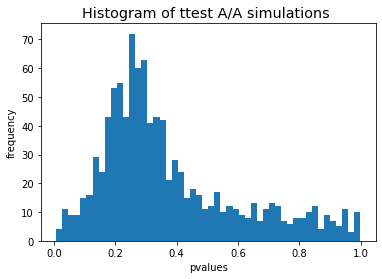

0.017

In [11]:
# running A/A-test for total revenues
get_AA(res_control_1.drop_duplicates(subset='uid').total_revenue,
       res_control_2.drop_duplicates(subset='uid').total_revenue)

FPR < p-value

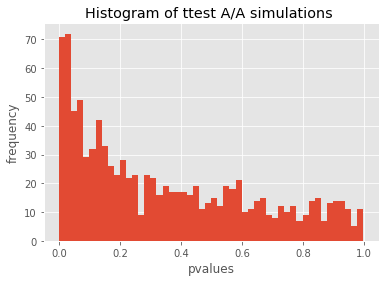

0.166

In [12]:
# running A/A-test for revenues
get_AA(res_control_1['revenue'], res_control_2['revenue'])

FPR > p-value, so we should look for data anomalies. We should also check revenue distribution in the control groups.

[12727.   16611.4  35412.52]


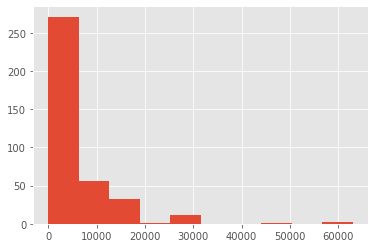

In [13]:
res_control_1.revenue.hist()
print(np.percentile(res_control_1.revenue, [90, 95, 99]))

In [14]:
# about 5% of users made transactions greater than 16611.4, we should take a look at them
res_control_1.query('revenue > 16611.4').sort_values(by='revenue', ascending=False)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,age,attraction_coeff,coins,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
277,892216461,United States of America,2017-10-18 14:41:00,2017-10-18 15:02:00,63037.0,147.0,autoreply_message,premium_no_trial,19,293,6.0,"1,2,3,5,8,9,11,13,15,16,17,18,19,20,22,23,24,2...",1,16,25,58,1.0,1.0,64298.0
317,891383310,Turkey,2017-04-11 20:47:00,2017-04-11 22:17:00,63037.0,147.0,autoreply_message,premium_no_trial,22,1000,NaN,1,1,19,83,4,1.0,1.0,63037.0
143,892333905,Italy,2017-10-16 01:38:00,2017-10-16 13:10:00,63037.0,147.0,no_sympathy,premium_no_trial,22,175,3608.0,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
30,892421277,United States of America,2017-10-14 13:05:00,2017-10-15 13:11:00,47723.0,147.0,promo_09,premium_no_trial,22,446,62.0,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,16,35,130,1.0,1.0,60333.0
335,892333905,Italy,2017-10-16 01:38:00,2017-10-17 20:53:00,31525.0,19.0,menu,coins,22,175,3608.0,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
316,892333905,Italy,2017-10-16 01:38:00,2017-10-16 02:52:00,31525.0,19.0,menu,coins,22,175,3608.0,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
306,892333905,Italy,2017-10-16 01:38:00,2017-10-16 10:24:00,31525.0,19.0,menu,coins,22,175,3608.0,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
304,892333905,Italy,2017-10-16 01:38:00,2017-10-16 02:26:00,31525.0,19.0,menu,coins,22,175,3608.0,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
297,892333905,Italy,2017-10-16 01:38:00,2017-10-16 02:26:00,31525.0,19.0,menu,coins,22,175,3608.0,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
256,892333905,Italy,2017-10-16 01:38:00,2017-10-17 00:40:00,31525.0,19.0,menu,coins,22,175,3608.0,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0


In [15]:
res_control_1.query('uid == 892333905')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,age,attraction_coeff,coins,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
6,892333905,Italy,2017-10-16 01:38:00,2017-10-16 02:08:00,12610.0,19.0,gifts,coins,22,175,3608.0,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
13,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type,22,175,3608.0,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
28,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:57:00,3783.0,67.0,empty_admins,other_type,22,175,3608.0,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
43,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type,22,175,3608.0,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
47,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type,22,175,3608.0,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
49,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:42:00,3783.0,67.0,menu,other_type,22,175,3608.0,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
63,892333905,Italy,2017-10-16 01:38:00,2017-10-16 22:35:00,31525.0,19.0,menu,coins,22,175,3608.0,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
76,892333905,Italy,2017-10-16 01:38:00,2017-10-16 18:42:00,31525.0,19.0,fans,coins,22,175,3608.0,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
88,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type,22,175,3608.0,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
126,892333905,Italy,2017-10-16 01:38:00,2017-10-16 22:39:00,19773.0,146.0,menu,coins,22,175,3608.0,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0


This user seems to be one of the most active users, having made 27 large transactions over 2 days.

In [16]:
round(res_control_1.query('uid == 892333905').revenue.sum() / res_control_1.revenue.sum()*100, 2)

18.62

This user's transactions are 18.62% of Control Group 1 revenue, so we can exclude these values as outliers.

In [17]:
res_control_1 = res_control_1.query('uid != 892333905')

[12682.8  12921.35 16941.47]


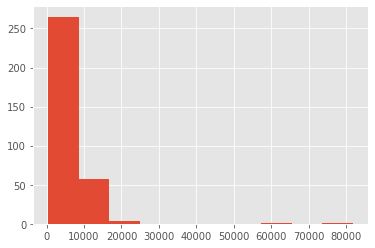

In [18]:
res_control_2.revenue.hist()
print(np.percentile(res_control_2.revenue, [90, 95, 99]))

In [19]:
# about 5% of users made transactions greater than 12921.35, let's take a look at them as well
res_control_2.query('revenue > 12921.35').sort_values(by='revenue', ascending=False)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,age,attraction_coeff,coins,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
47,891778551,United Arab Emirates,2017-10-27 21:26:00,2017-10-27 22:30:00,81796,147,left_sidebar_menu,premium_no_trial,30,290,NaN,"1,6,7,8,9,10",1,27,33,31,1.0,1.0,81796
22,892307238,Spain,2017-10-16 16:01:00,2017-10-16 20:41:00,63037,147,left_sidebar_menu,premium_no_trial,29,543,43.0,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,16,36,46,1.0,1.0,75647
97,891664350,Germany,2017-10-30 00:21:00,2017-03-11 02:57:00,19513,146,empty_likes,coins,34,242,271.0,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",1,17,41,541,1.0,1.0,28119
71,891328884,Italy,2017-05-11 17:44:00,2017-11-13 19:45:00,16952,147,trial_vip_popup,trial_premium,44,0,NaN,"1,2,4,5,7,8,9",1,41,47,0,1.0,1.0,16952
212,891950754,Portugal,2017-10-24 06:24:00,2017-10-31 08:39:00,16913,147,left_sidebar_menu,trial_premium,34,151,NaN,"1,2,3,5,7,9,10,11",1,16,56,33,1.0,1.0,16913
93,892215174,Belgium,2017-10-18 15:17:00,2017-10-25 17:17:00,16835,147,trial_vip_popup,trial_premium,41,0,NaN,1,1,38,44,4,1.0,1.0,16835
152,891436977,Spain,2017-03-11 20:48:00,2017-10-11 22:48:00,16666,147,trial_vip_popup,trial_premium,43,571,NaN,"1,2",1,23,36,7,1.0,1.0,16666
121,891962115,Spain,2017-10-23 22:53:00,2017-10-31 00:54:00,16653,147,trial_vip_popup,trial_premium,44,222,NaN,NaN,1,41,47,9,1.0,1.0,16653
323,891985866,Belgium,2017-10-23 13:19:00,2017-10-30 15:35:00,16640,147,trial_vip_popup,trial_premium,34,349,4.0,"1,2,3,4,5,6,7,8,10,11,12,14,16,17,19,21,22",1,21,99,63,1.0,1.0,20605
313,891691062,Belgium,2017-10-29 16:19:00,2017-05-11 18:35:00,16614,147,popular_users_block,trial_premium,30,0,NaN,1,1,27,33,0,1.0,1.0,16614


Nothing here looks like an anomaly, so we can run A/A-test again.

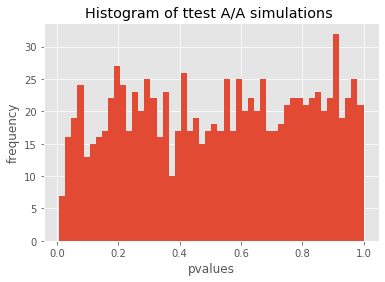

0.024

In [20]:
get_AA(res_control_1['revenue'], res_control_2['revenue'])

FRP < 0.05, so we can do further analysis.
## Control Group 1 vs. Test Group

In [21]:
# calculating conversion
conversion_control_1 = res_control_1.uid.nunique() / users_control_1.uid.nunique()
conversion_test = res_test.uid.nunique() / users_test.uid.nunique()
print(f'Control Group 1 conversion:{conversion_control_1: .2%}')
print(f'Test Group conversion:{conversion_test: .2%}')

Control Group 1 conversion: 4.42%
Test Group conversion: 3.39%


In [22]:
# mean revenue
print(f'Control Group 1 mean revenue: {round(res_control_1.revenue.mean(),2)}')
print(f'Test Group mean revenue: {round(res_test.revenue.mean(),2)}')
print(f'Revenue increased by {(res_test.revenue.mean()-res_control_1.revenue.mean())/res_control_1.revenue.mean():.2%}')

Control Group 1 mean revenue: 6074.23
Test Group mean revenue: 8589.38
Revenue increased by 41.41%


[13891.8  16621.8  35041.24]


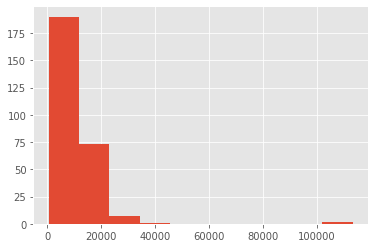

In [23]:
# checking for anomalies in the test group
res_test.revenue.hist()
print(np.percentile(res_test.revenue, [90, 95, 99]))

In [24]:
res_test.query('revenue > 16621.8').sort_values(by='revenue', ascending=False)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,age,attraction_coeff,coins,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
12,891178380,Spain,2017-08-11 03:54:00,2017-09-11 21:53:00,113477,147,promo_09,premium_no_trial,42,275,85.0,"1,2,4,5,6,7",1,26,36,287,1.0,1.0,129870
196,892038759,United Arab Emirates,2017-10-22 11:12:00,2017-10-22 16:23:00,113477,147,autoreply_message,premium_no_trial,26,323,3.0,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,23,48,232,1.0,1.0,123565
64,892275462,France,2017-10-17 05:56:00,2017-02-11 18:24:00,44083,19,coins_popup,other_type,31,310,NaN,"1,2,3,4,5,9,13,15,16",1,36,68,58,1.0,1.0,14885
44,891346269,Argentina,2017-05-11 12:55:00,2017-07-11 11:28:00,31525,19,empty_likes,coins,34,204,530.0,"1,2,3,4,5,6,7,9,10",1,16,37,44,1.0,1.0,75647
81,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:14:00,31525,19,menu,coins,23,262,378.0,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,1.0,1.0,95823
169,891914619,United States of America,2017-10-24 23:12:00,2017-10-25 21:22:00,31525,19,empty_likes,coins,45,371,253.0,"1,2,3,4",1,30,43,493,1.0,NaN,35308
202,891346269,Argentina,2017-05-11 12:55:00,2017-07-11 11:27:00,31525,19,empty_likes,coins,34,204,530.0,"1,2,3,4,5,6,7,9,10",1,16,37,44,1.0,1.0,75647
216,892150854,Argentina,2017-10-20 00:25:00,2017-10-30 02:14:00,31525,19,empty_likes,coins,38,329,204.0,"1,2,3,4,5,6,10,11,12,13,14,15,16,17,18,19,20,2...",1,35,41,231,1.0,1.0,61789
259,892248561,Germany,2017-10-17 20:06:00,2017-10-18 20:35:00,31525,19,empty_likes,coins,22,106,192.0,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,16,26,198,1.0,1.0,38779
14,892150854,Argentina,2017-10-20 00:25:00,2017-10-23 01:31:00,30264,68,super_popup,other_type,38,329,204.0,"1,2,3,4,5,6,10,11,12,13,14,15,16,17,18,19,20,2...",1,35,41,231,1.0,1.0,61789


(0.5871440768241882, 5.1500055232869805e-28)


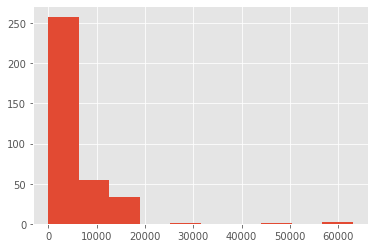

In [25]:
# No signs of anomalies, then using normality test
res_control_1.revenue.hist()
print(stats.shapiro(res_control_1.revenue))

(0.4980769753456116, 3.996793050437411e-27)


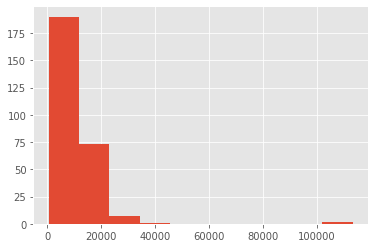

In [26]:
res_test.revenue.hist()
print(stats.shapiro(res_test.revenue))

According to the Shapiro-Wilk test, the revenue values are not normally distributed, so we should use bootstrap method for analysis.

In [27]:
def get_bootstrap(col1, col2, boot_it=1000, statistic=np.mean, bootstrap_conf_level=0.95):
    """
        col1: first sample values
        col2: second sample values
        boot_it: number of bootstrap subsamples
        statistic: statistical value
        bootstrap_conf_level: confidence level
    """
    boot_len = max(len(col1), len(col2))
    boot_data = []
    for i in range(boot_it):
        samples_1 = col1.sample(boot_len, replace=True).values
        samples_2 = col2.sample(boot_len, replace=True).values
        boot_data.append(statistic(samples_1-samples_2))       
    pd_boot_data = pd.DataFrame(boot_data)
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    p_1 = stats.norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    p_2 = stats.norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    p_value = min(p_1, p_2) * 2
    
    return {"boot_data": boot_data, "ci": ci, "p_value": p_value, "pd_boot_data": pd_boot_data}


def bootstrap_plot(boot_dict):
    plt.hist((boot_dict['pd_boot_data'])[0], bins=50)
    plt.style.use('ggplot')
    plt.vlines(boot_dict['ci'], ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

p-value: 0.00020130411199469056


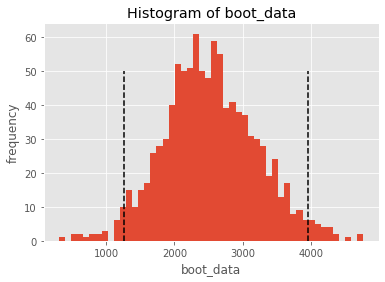

In [28]:
boot_data_mean = get_bootstrap(res_test.revenue, res_control_1.revenue)
print(f'p-value: {boot_data_mean["p_value"]}')
bootstrap_plot(boot_data_mean)

p < 0.05, so we can reject the zero hypothesis on absence of significant difference between user groups. 

p-value: 0.0010109885789142947


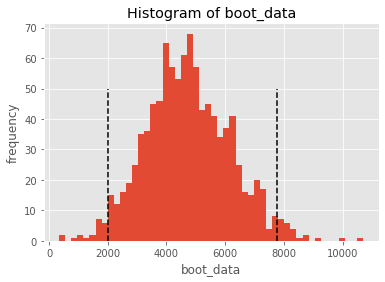

In [29]:
# using bootstrap for total revenue values
control = res_control_1.drop_duplicates(subset='uid').total_revenue
test = res_test.drop_duplicates(subset='uid').total_revenue
boot_data_mean = get_bootstrap(test, control)
print(f'p-value: {boot_data_mean["p_value"]}')
bootstrap_plot(boot_data_mean)

p < 0.05, so we can reject the zero hypothesis here as well.  
Also, we should analyse user subgroups by product type (trial premium, full premium, premium by coins and other), applying Bonferroni correction.

In [30]:
def compare_groups(df1, df2, groups):
    pvalues = []
    for group in groups:
        control = df1.drop_duplicates(subset='uid').query(group).total_revenue
        test = df2.drop_duplicates(subset='uid').query(group).total_revenue
        p_value = get_bootstrap(test, control)["p_value"]
        pvalues.append(p_value)

    group_table = pd.DataFrame()
    group_table['group'] = groups
    group_table['p-value'] = pvalues
    group_table['Bonferroni_correction'] = bonferroni(pvalues, alpha = 0.05)
    return group_table

In [31]:
product_types = ['product_type == "trial_premium"', 'product_type == "premium_no_trial"',
                 'product_type == "coins"', 'product_type == "other_type"']
compare_groups(res_control_1, res_test, product_types)

,group,p-value,Bonferroni_correction
0,"product_type == ""trial_premium""",0.000591,True
1,"product_type == ""premium_no_trial""",0.063796,False
2,"product_type == ""coins""",0.216046,False
3,"product_type == ""other_type""",0.034379,False


There's a significant difference only between control and test group with trial premium subscription.  
## Analyzing new options impact on subgroups

In [32]:
control_1_tp = res_control_1.query('product_type == "trial_premium"')
test_tp = res_test.query('product_type == "trial_premium"') 

In [33]:
# analyzing gender groups
control_1_tp.drop_duplicates(subset='uid').gender.value_counts()

1    63
0     4
Name: gender, dtype: int64

In [34]:
test_tp.drop_duplicates(subset='uid').gender.value_counts()

1    59
0     2
Name: gender, dtype: int64

It's unclear which gender is '1' and which is '0', though we could asume that the majority of the app users are male.

In [35]:
# analyzing age groups
test_tp.drop_duplicates(subset='uid').query('age < 99').age.quantile([0.25, 0.5, 0.75])

0.25    26.0
0.50    33.0
0.75    37.0
Name: age, dtype: float64

In [36]:
age_groups = ['age <= 26', '26 < age <= 33', '33 < age <= 37', '37 < age < 99']
compare_groups(control_1_tp, test_tp, age_groups)

,group,p-value,Bonferroni_correction
0,age <= 26,0.001153,True
1,26 < age <= 33,0.044566,False
2,33 < age <= 37,0.149289,False
3,37 < age < 99,0.498183,False


There's a significant difference only between control and test group of age under 27. Let's take a look at the conversion rate in this age group.

In [37]:
def conversion_rate(subgroup):
    conversion_control = (control_1_tp.drop_duplicates(subset='uid').query(subgroup).shape[0] /
                          users_control_1.drop_duplicates(subset='uid').query(subgroup).shape[0])
    converstion_test = (test_tp.drop_duplicates(subset='uid').query(subgroup).shape[0] / 
                        users_test.drop_duplicates(subset='uid').query(subgroup).shape[0])
    print(f'Conversion in Control Group: {conversion_control:.2%}')
    print(f'Conversion in Test Group: {conversion_test:.2%}')

In [38]:
conversion_rate('age <= 26')

Conversion in Control Group: 1.26%
Conversion in Test Group: 3.39%


In [39]:
# analyzing attraction coefficient
control_1_tp.drop_duplicates(subset='uid').attraction_coeff.quantile([0.25, 0.5, 0.75]) 

0.25    146.0
0.50    260.0
0.75    434.0
Name: attraction_coeff, dtype: float64

In [40]:
attr_groups = ['attraction_coeff <= 146', '146 < attraction_coeff <= 260',
               '260 < attraction_coeff <= 434', 'attraction_coeff > 434']
compare_groups(control_1_tp, test_tp, attr_groups)

,group,p-value,Bonferroni_correction
0,attraction_coeff <= 146,0.003080,True
1,146 < attraction_coeff <= 260,0.484268,False
2,260 < attraction_coeff <= 434,0.045855,False
3,attraction_coeff > 434,0.048171,False


There's a significant difference only between control and test group with attraction coefficient not greater than 146.

In [41]:
conversion_rate('attraction_coeff <= 146')

Conversion in Control Group: 0.92%
Conversion in Test Group: 3.39%


In [42]:
# analyzing visits after registration
control_1_tp['visit_days_count'] = control_1_tp['visit_days'].apply(lambda x: len(str(x).split(',')))
test_tp['visit_days_count'] = test_tp['visit_days'].apply(lambda x: len(str(x).split(',')))
users_control_1['visit_days_count'] = users_control_1['visit_days'].apply(lambda x: len(str(x).split(',')))
users_test['visit_days_count'] = users_test['visit_days'].apply(lambda x: len(str(x).split(',')))

# checking for users who made transactions but have no saved visits in the dataset
test_tp.visit_days_count.isna().sum()

0

In [43]:
test_tp.drop_duplicates(subset='uid').visit_days_count.quantile([0.25, 0.5, 0.75])

0.25    1.0
0.50    3.0
0.75    9.0
Name: visit_days_count, dtype: float64

In [44]:
visit_groups = ['visit_days_count <= 1', '1 < visit_days_count <= 3',
                '3 < visit_days_count <= 9', 'visit_days_count > 9']
compare_groups(control_1_tp, test_tp, visit_groups)

,group,p-value,Bonferroni_correction
0,visit_days_count <= 1,0.169345,False
1,1 < visit_days_count <= 3,0.083226,False
2,3 < visit_days_count <= 9,0.003099,True
3,visit_days_count > 9,0.001058,True


There is a significant difference between control group and group of users who visited in 3-9 days after registration and between control group and test group of users who visited in more than 9 days after registration.

In [45]:
conversion_rate('3 < visit_days_count <= 9')

Conversion in Control Group: 1.85%
Conversion in Test Group: 3.39%


In [46]:
conversion_rate('visit_days_count > 9')

Conversion in Control Group: 2.97%
Conversion in Test Group: 3.39%


## Results
We can say that the experiment was pretty successful. The significant result was achieved for the test group with trial premium subscription, their mean revenue and conversion rate increased comparing to the control group. The new options seem to have impacted several groups of users who seem to belong to the target audience, their mean revenue and conversion rate also increased. These groups are:
* Users under age of 26
* Frequent users (visited in 3-9 and more days after registration)
* Users with attraction coefficient not greater than 146